# Tutorial 11-2: The Missing Piece – "Image Inpainting with Context Encoders"

**Course:** CSEN 342: Deep Learning  
**Topic:** Unsupervised Learning, Autoencoders, and Image Inpainting

## Objective
In the lecture, we discussed **Context Encoders** (Slide 15). This is a form of self-supervised learning where we hide a part of the data and ask the model to predict it.

By forcing the model to fill in a missing hole (Inpainting), we force it to understand the **semantics** of the object. For example, to fill in a missing eye on a face, the model must first understand that the object is a face and that faces typically have two symmetric eyes.

In this tutorial, we will:
1.  **Mask Data:** Take CIFAR-10 images and remove a center patch.
2.  **Build a Context Encoder:** A Convolutional Autoencoder designed to predict missing pixels.
3.  **Train:** Optimize the L2 Reconstruction Loss.
4.  **Visualize:** Compare the "Hallucinated" patch with the real one.

---

## Part 1: Data Preparation & Masking

We use **CIFAR-10**. The images are $32\times32$. We will mask out the central $10\times10$ square.

This simulates the "Center Region" masking strategy shown in **Slide 16**[cite: 5596].

Files already downloaded and verified
Files already downloaded and verified


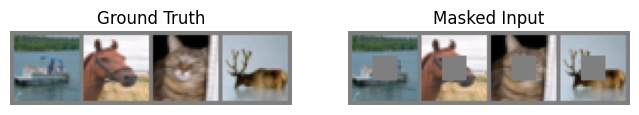

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os

# 1. Setup Path
data_root = '../data'
os.makedirs(data_root, exist_ok=True)

# 2. Define Transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    # Standard CIFAR-10 normalization
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# 3. Download CIFAR-10
print("Downloading CIFAR-10...")
train_set = torchvision.datasets.CIFAR10(root=data_root, train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root=data_root, train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=16, shuffle=True)

# 4. Masking Function
def apply_center_mask(images, mask_size=12):
    """
    Replaces the center of the image with gray pixels (0.0 in normalized tensor).
    images: (Batch, 3, 32, 32)
    """
    masked_images = images.clone()
    # CIFAR is 32x32. Center is 16, 16.
    start = (32 - mask_size) // 2
    end = start + mask_size
    
    # Mask out the block (set to 0, which is gray in normalized [-1, 1] space)
    masked_images[:, :, start:end, start:end] = 0.0
    return masked_images

# Visualization
images, _ = next(iter(test_loader))
masked = apply_center_mask(images)

def imshow(img, title):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.axis('off')

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1); imshow(torchvision.utils.make_grid(images[:4]), "Ground Truth")
plt.subplot(1, 2, 2); imshow(torchvision.utils.make_grid(masked[:4]), "Masked Input")
plt.show()

---

## Part 2: The Context Encoder Architecture

We build an Encoder-Decoder network. 

* **Encoder:** Compresses the image ($3 \times 32 \times 32$) into a small latent vector using Convolutional layers.
* **Decoder:** Expands the latent vector back to the original image size using `ConvTranspose2d`.

This mirrors the architecture diagram in **Slide 17**[cite: 5601], but adapted for the smaller CIFAR-10 image size.

In [2]:
class ContextEncoder(nn.Module):
    def __init__(self):
        super(ContextEncoder, self).__init__()
        
        # --- Encoder (Compress) ---
        self.encoder = nn.Sequential(
            # Input: 3 x 32 x 32
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),  # -> 32 x 16 x 16
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1), # -> 64 x 8 x 8
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1), # -> 128 x 4 x 4
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
        )
        
        # --- Bottleneck ---
        # The "Channel-wise Fully Connected" layer mentioned in Slide 15 is often
        # replaced by standard Conv layers in simple implementations.
        # Here we rely on the 128x4x4 feature map as the latent code.

        # --- Decoder (Reconstruct) ---
        self.decoder = nn.Sequential(
            # Input: 128 x 4 x 4
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1), # -> 64 x 8 x 8
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1), # -> 32 x 16 x 16
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),  # -> 3 x 32 x 32
            nn.Tanh() # Output range [-1, 1]
        )

    def forward(self, x):
        z = self.encoder(x)
        reconstruction = self.decoder(z)
        return reconstruction

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ContextEncoder().to(device)
print("Context Encoder Initialized.")

Context Encoder Initialized.


---

## Part 3: Training Loop

The loss function is the critical component here. As per **Slide 15**, we calculate the reconstruction loss $\mathcal{L}$.

$$ \mathcal{L} = || \text{Decoder}(\text{Masked}) - \text{Original} ||^2 $$

We can optionally weight the loss to prioritize the center "hole" region, but a global MSE works well for this introductory tutorial.

In [3]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.5, 0.999))
epochs = 5

print("Starting Training...")

for epoch in range(epochs):
    total_loss = 0
    for i, (real_images, _) in enumerate(train_loader):
        real_images = real_images.to(device)
        
        # 1. Mask the input
        masked_input = apply_center_mask(real_images).to(device)
        
        # 2. Forward Pass
        optimizer.zero_grad()
        outputs = model(masked_input)
        
        # 3. Compute Loss
        # We compare the predicted output against the original real image
        loss = criterion(outputs, real_images)
        
        # 4. Backward
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
    print(f"Epoch [{epoch+1}/{epochs}] Loss: {total_loss/len(train_loader):.4f}")

print("Training Complete.")

Starting Training...
Epoch [1/5] Loss: 0.0409
Epoch [2/5] Loss: 0.0232
Epoch [3/5] Loss: 0.0208
Epoch [4/5] Loss: 0.0196
Epoch [5/5] Loss: 0.0187
Training Complete.


---

## Part 4: The Results (Inpainting)

Now we test the model on unseen images. We will display:
1.  **Masked Input:** What the model sees (the image with the hole).
2.  **Inpainted Output:** The model's hallucination.
3.  **Ground Truth:** The actual original image.

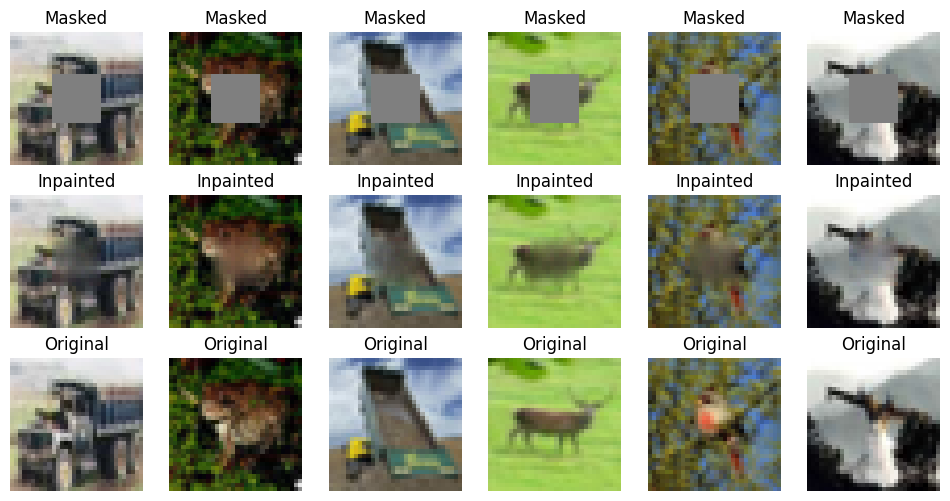

In [4]:
model.eval()

# Get a batch of test images
real_images, _ = next(iter(test_loader))
masked_input = apply_center_mask(real_images).to(device)

with torch.no_grad():
    reconstructed = model(masked_input).cpu()

# Helper to overlay the reconstruction onto the mask
# This ensures we only look at the 'filled in' part for visual clarity
def composite_image(original_masked, generated, mask_size=12):
    comp = original_masked.clone()
    start = (32 - mask_size) // 2
    end = start + mask_size
    # Paste the generated center into the masked image
    comp[:, :, start:end, start:end] = generated[:, :, start:end, start:end]
    return comp

composited = composite_image(masked_input.cpu(), reconstructed)

# Plotting
plt.figure(figsize=(12, 6))
for i in range(6):
    # Masked
    plt.subplot(3, 6, i + 1)
    imshow(masked_input[i].cpu(), "Masked")
    
    # Inpainted (Composite)
    plt.subplot(3, 6, i + 7)
    imshow(composited[i], "Inpainted")
    
    # Original
    plt.subplot(3, 6, i + 13)
    imshow(real_images[i], "Original")

plt.show()

### Discussion

Look at the "Inpainted" row. Does the model generate plausible content?

* **Structure:** If there is a car, does the model continue the windshield? If there is a horse, does it fill in the body color correctly?
* **Blurriness:** Autoencoders trained with MSE loss tend to produce blurry results because they average all possible valid completions. To get sharper results (like in **Slide 17**'s reconstruction), researchers often add an **Adversarial Loss** (using a Discriminator, similar to a GAN, which you'll learn about next) to force realistic texture.

This technique allows models to learn rich feature representations from vast amounts of unlabeled images found on the internet.